##  A pipeline for using BS-Seq data to identify the Transposable elements insertion sites

In [6]:
from IPython import display

`source /home/czhao/My_project/BSTI/bin/source.bash`

###  1. An introduction for this pipeline

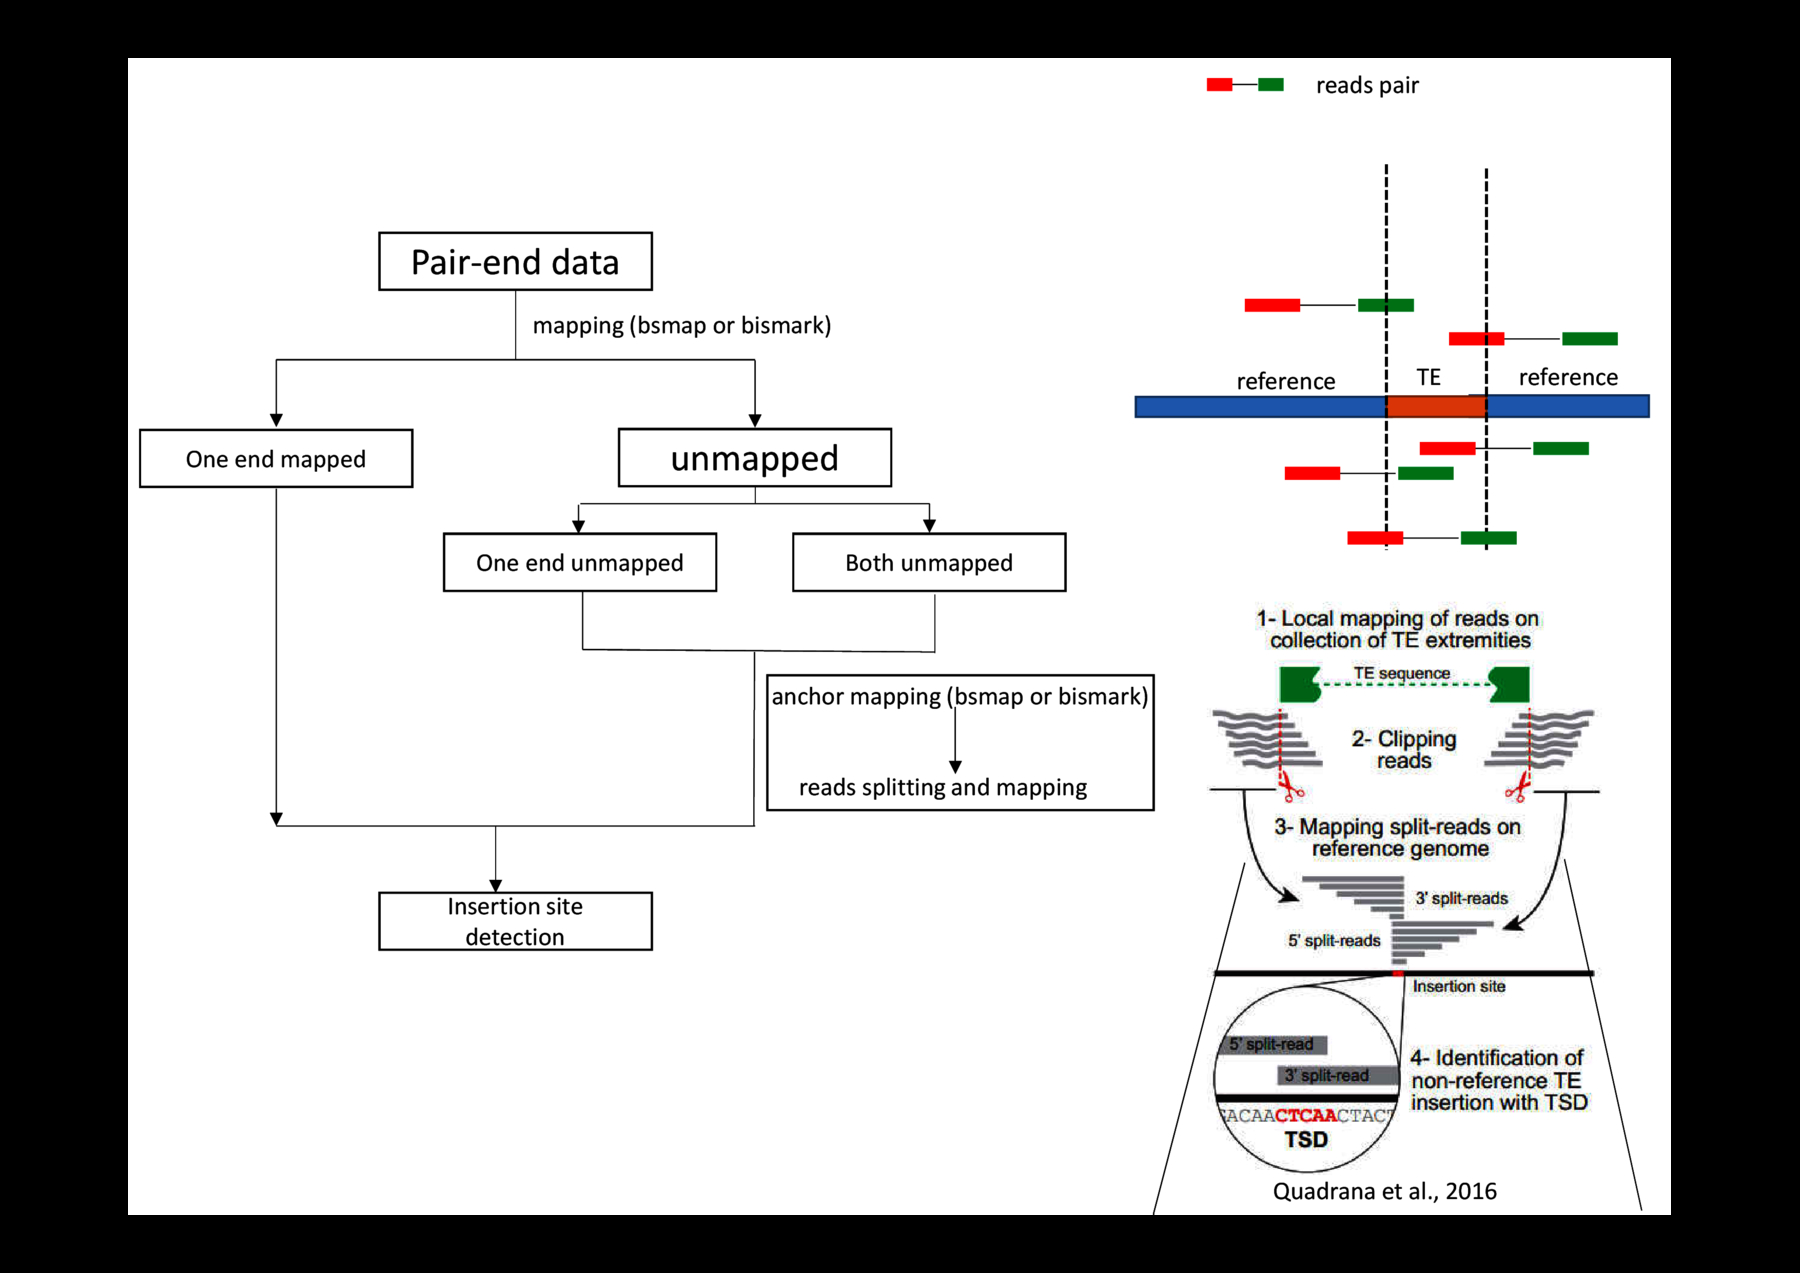

In [7]:
display.Image("notebook_material/BSTI_pipeline-0.jpeg")

This pipeline is kind of like the identification of circRNAs. Both of them need to do the anchor mapping, split reads mapping. Note: [TSD:short target site duplications](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4917339/).

###  2. Building mimic BS-data

We need to build the mimic insertion reference and BS-Seq data.
`bash $BIN/mimic_BS_fastq.bash`

Details:

`awk '{if ($3-$2 > 300) print $0}' /oldgroupshare/bioinformatics/zhaocheng/Genome/ATH/TE/TE_bedlike.bed|sortBed |mergeBed -s -c 4 -o collapse |awk '{OFS="\t";print $1,$2,$3,"Region"NR,$5,$4}' > Suspect_TE.temp.bed
fastaFromBed -fi arab10.C.fa -bed Suspect_TE.temp.bed -s -name -fo Suspect_TE.temp.fa
cd-hit-est -i Suspect_TE.temp.fa -o Suspect_TE.fa -c 0.99 -n 8 -T 20`

Note: To avoid the multiple mapping, We clustered the TE seqence which is longer 300bp. 

`python3 $SRC/TE_insertion_make_bed.py TAIR10.bg Suspect_TE.ID 50 6 > $DATA/mimic_BS/Insertion.bed.back`

Note: Randomly selecting insertion sites and randomly generated 0~6bp TSDs.

`/home/czhao/tools/Sherman -l 125 -n 35000000 --genome_folder  /home/czhao/My_project/BSTI/data/mimic_BS/genome_folder -pe -CG 0.09 -CH 0.02`

Note: Tools [Sherman](https://www.bioinformatics.babraham.ac.uk/projects/sherman/) is used to build the mimic BS-Seq data.


###  3. Analysis pipelines

`qsub $BIN/TE_transition_bsmap.bash` ## Using bsmap as the mapping tools

`qsub $BIN/TE_transition_bismark.bash` ## Using bismark as the mapping tools

bismark is more accqurate than bsmap, however, bsmap is more quicker than bismark.

Two pipelne for two tools. Pipeline using bismark works for less candidated reads.


####  3.1 Pipeline using bsmap

3.1.1 Clean reads are mapped to reference

`/home/czhao/tools/bsmap-2.90/bsmap -a $TMPD/clean_data/${ARRAY[$SGE_TASK_ID]}_Rclean_R1.fastq -b $TMPD/clean_data/${ARRAY[$SGE_TASK_ID]}_Rclean_R2.fastq -d $REF -o $TMPD/${ARRAY[$SGE_TASK_ID]}/BSTI_bsmap/${ARRAY[$SGE_TASK_ID]}_bsmap.bsp -u -v 2 -p 24 -S 1 2>$TMPD/.${ARRAY[$SGE_TASK_ID]}_11`

3.1.2 Getting pairs unmapped reads

`
awk '{if ($3 == "*") print $0}'  ${ARRAY[$SGE_TASK_ID]}_bsmap.sam | cut -f 1 |sort |uniq > Unmapped.reads.ID
perl $SRC/TE_move/Unmapped_fastq_pick.pl Unmapped.reads.ID $TMPD/clean_data/${ARRAY[$SGE_TASK_ID]}_Rclean_R1.fastq $TMPD/clean_data/${ARRAY[$SGE_TASK_ID]}_Rclean_R2.fastq unmapped.R1.fastq unmapped.R2.fastq`
`

3.1.3 Getting SE unmapped/mapped reads 

 Mapping to TE sequence and genome reference

`cat unmapped.R1.fa unmapped.R2.fa > unmapped.fa  ## total pairs unmapped reads
cat unmapped.R1.TE.bed unmapped.R2.TE.bed  > unmapped.TE.bed ## Pairs unmapped reads treat as SE mapped to  TE sequence
cat unmapped.R1.ref.bed unmapped.R2.ref.bed  > unmapped.ref.bed ## Pairs unmapped reads treat as SE mapped to genome sequence 
cut -f 4 unmapped.TE.bed unmapped.ref.bed |sort |uniq > filtered.mapped.ID  ### # this seq isn't used for spliting
`

3.1.4 Only SE mapped and both unmapped reads are used for anchor mapping, spliting and mapping

`python $SRC/TE_move/split_anchors.py unmapped.fa unmapped.anch.fa` ## Anchor(left and right 20bp of each reads)
 
 anchor sequence mapped on TE sequence and genome reference
 
 only anchor mapped reads are used for spliting and mapping
 
 `python3 $SRC/TE_move/split_breakpoints.py unmapped.cand.fa > unmapped.cand.split.fa` ## reads spliting
 
 `/home/czhao/tools/bsmap-2.90/bsmap -a  unmapped.cand.split.fa -d $TE -o unmapped.cand.split.TE.bsp -r 0 -v 2 -p 24 -S 1` ## reads mapping
 

3.1.5 Identification of insertion sites.

Informative reads type

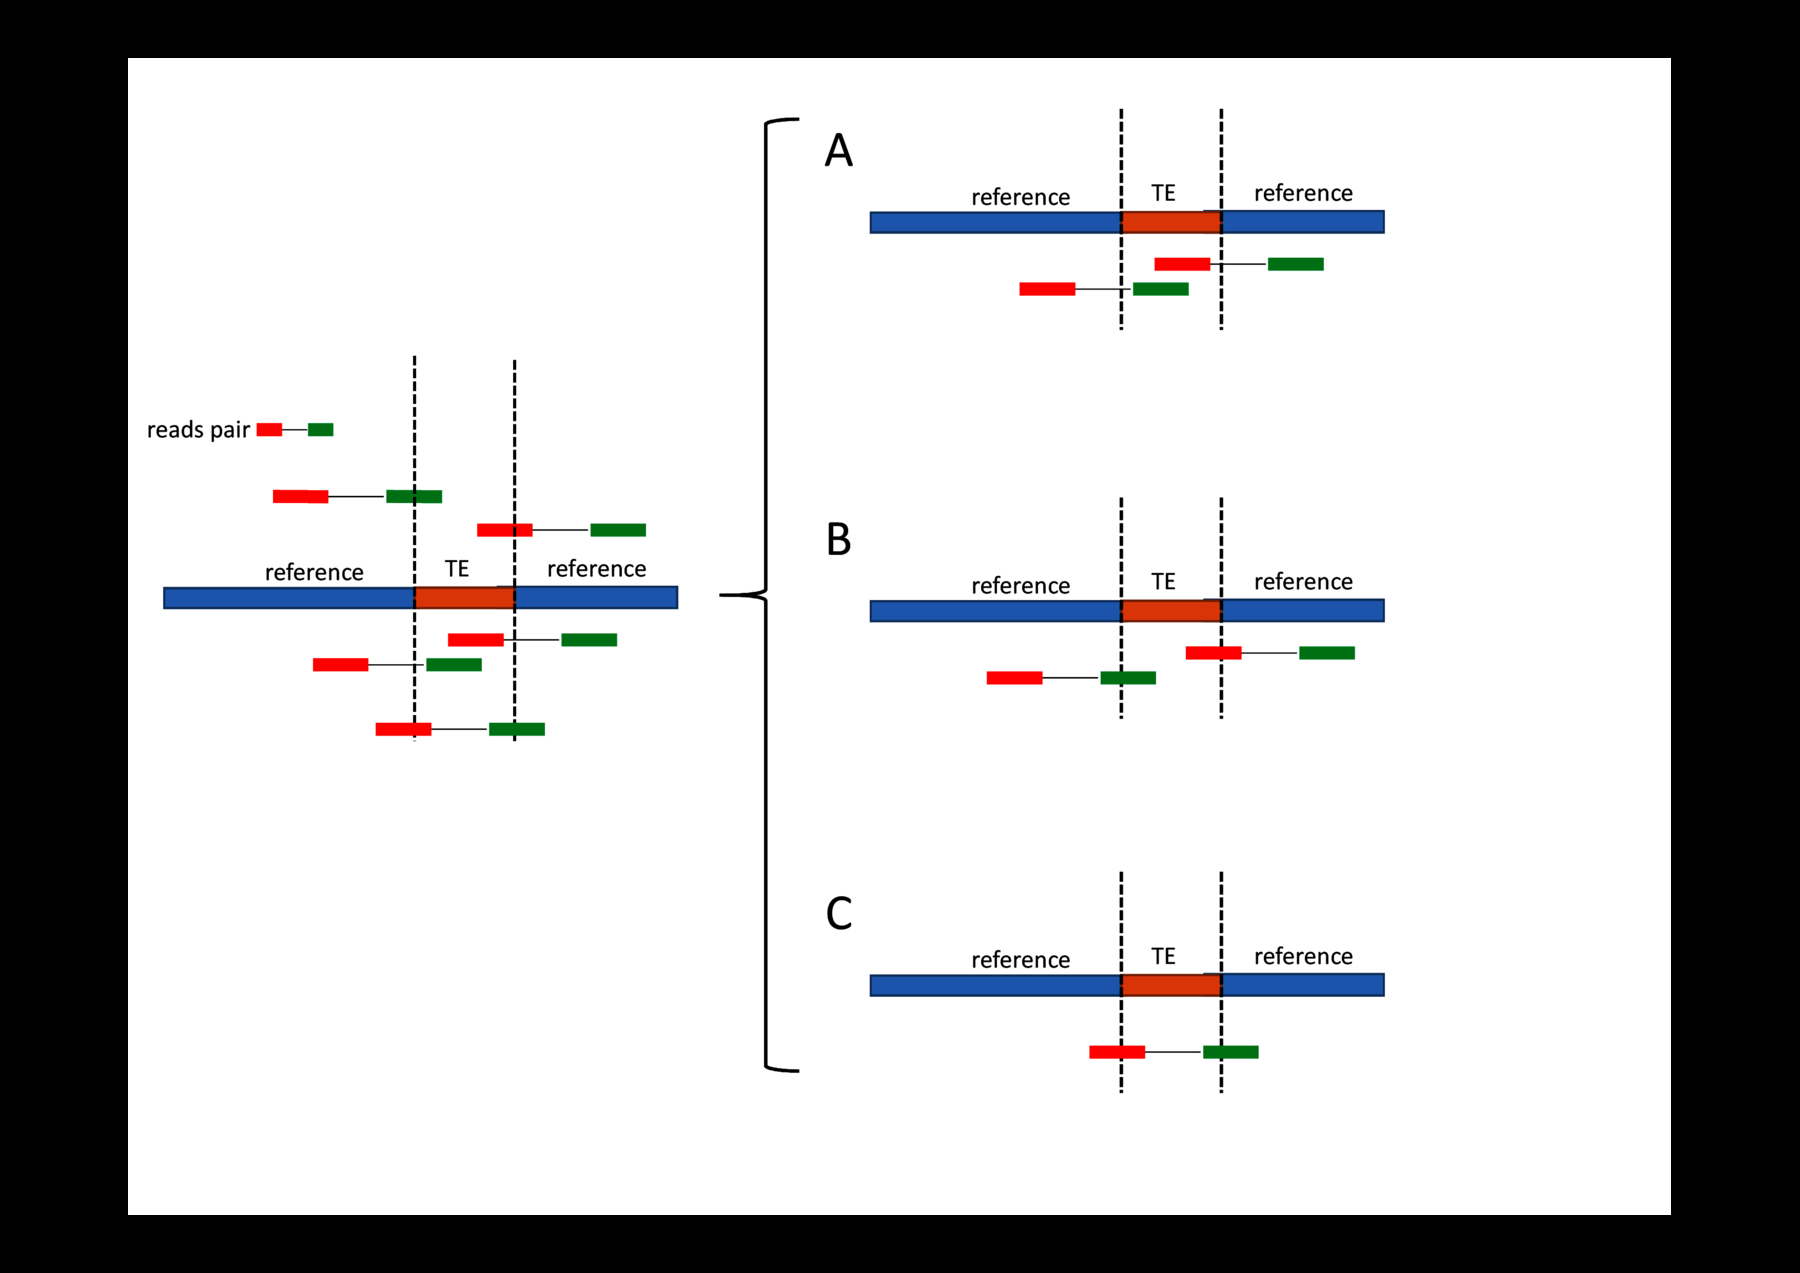

In [8]:
display.Image("notebook_material/BSTI_pipeline-1.jpeg")

Type-A mapping can't give a precise insertion sites

`cat  ambigious.reads.out|awk '{OFS="\t";if ($7 eq "R1") print $6,$19"|"$20"^"$5"("$2"|"$3"|"$4"|"$5")^"$21"|"$10;else if ($7 eq "R2") print $6,$19"|"$20"^"$5"("$2"|"$3"|"$4"|"$5")^"$21"|"$16}'|perl $SRC/TE_move/choose_the_best.pl > ambigious.output
`

Type-B can give a precise insertion sites

`join -1 4 -2 1 -t$'\t' <(sort -k4,4 $DOC/Suspect_TE.bed|cut -f 1-5)  <(paste unmapped.cand.split.part1 unmapped.cand.split.part2|sed -e 's/R1_/R1\t/g'|sed -e 's/R2_/R2\t/g'|sort -k1,1)|awk '{OFS="\t";print $1,$2,$3,$4,$5,$9,$8,$3+$6,$3+$7,$11,$12,$16,$13,$14,$15,$19,$20}'|sort |uniq |perl $SRC/TE_move/not_ambigious_combine.pl unmapped.ref.bed |perl $SRC/TE_move/not_ambigious_judge.pl > not.ambigious.reads.out.part1`


Type-C can give a precise insertion sites and TSDs.

`join -1 4 -2 1 -t$'\t' <(sort -k4,4 $DOC/Suspect_TE.bed|cut -f 1-5)  <(paste unmapped.cand.split.part1 unmapped.cand.split.part2|sed -e 's/R1_/R1\t/g'|sed -e 's/R2_/R2\t/g'|sort -k1,1)|awk '{OFS="\t";print $1,$2,$3,$4,$5,$9,$8,$3+$6,$3+$7,$11,$12,$16,$13,$14,$15,$19,$20}'|sort |uniq |perl $SRC/TE_move/not_ambigious_judge_four_join.pl > not.ambigious.reads.out.part2`

Combine resutls

`cat  ambigious.reads.out|awk '{OFS="\t";if ($7 eq "R1") print $6,$19"|"$20"^"$5"("$2"|"$3"|"$4"|"$5")^"$21"|"$10;else if ($7 eq "R2") print $6,$19"|"$20"^"$5"("$2"|"$3"|"$4"|"$5")^"$21"|"$16}'|perl $SRC/TE_move/choose_the_best.pl > ambigious.output`

`cat not.ambigious.output  |cut -f 2 |sed -e 's/\^/\t/g'|sed -e 's/(/\t/'|cut -f 1,2,4 |sed -e 's/|/\t/g' |awk '{OFS="\t";print $1,$2,$4,$3,$4-$2,$5}'|sortBed  > insert.output.bed
`



`cut -f 2  not.ambigious.output|sort|uniq|cut -f 1,3 -d "^"|sed -e 's/\^/\t/'|sed -e 's/|/\t/g'|cut -f1-3 |sortBed |mergeBed|wc -l`
`intersectBed -a <(cat $DATA/mimic_BS/Insertion.bed.stat|awk '{OFS="\t";print $1,$2-5,$2+5,$3,$4,$5,$6}') -b <(cut -f 2  not.ambigious.output|sort|uniq|cut -f 1,3 -d "^"|sed -e 's/\^/\t/'|sed -e 's/|/\t/g'|cut -f1-3 |sortBed |mergeBed ) -c |cut -f 8 |sort|uniq -c`

Note: We identified 35 insertion sites and 21 of them are true positive insertion sites.Total 37 intersion sites.

####  3.2 Pipeline using bismark. 
It is similar to the pipeline of bsmap.
Note: We identified 89 insertion sites and 33 of them are true positive insertion sites.
Total 37 intersion sites.